# Visualize 3D object detection output
This notebook contains how to reproduce a video file like [here](https://github.com/Owen-Liuyuxuan/visualDet3D/blob/master/docs/stereo3d.md).

# Install Dependencies

In [ ]:
# Git Clone Repo
!git clone https://github.com/jingwoo4710/visualDet3D.git

Cloning into 'visualDet3D'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 254 (delta 86), reused 217 (delta 49), pack-reused 0
Receiving objects: 100% (254/254), 24.25 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
%cd /content/visualDet3D/
!pip3 install -r requirement.txt

/content/visualDet3D
     |████████████████████████████████| 92kB 3.7MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 92kB 7.9MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=4f742fe2c67f50c62f4b262b9485e3acd87143087334466773550dd071111e9b
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire


In [ ]:
# build ops (deform convs and iou3d), We will not install operations into the system environment
!./make.sh

/content/visualDet3D/visualDet3D/networks/lib/ops/dcn /content/visualDet3D
running build_ext
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:369: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
building '..deform_conv_ext' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/src
creating build/temp.linux-x86_64-3.7/src/cuda
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -I/usr/local/cuda/include -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DWITH_CUDA -I/usr/local/lib/python3.7/dist-packages/torch/include -I/usr/local/lib/python3.7/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.7/d

# Data Load

In [ ]:
# Google Drive Mount where raw datset is
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create Dataset Folder 
%mkdir /content/visualDet3D/visualDet3D/data/kitti_obj

In [ ]:
# Data Download from Google Drive
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_calib.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj/
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_image_2.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj/
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_image_3.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj/
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_label_2.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj/

# Sequential image data
!unzip -qq "/content/drive/MyDrive/project_2_dataset/2011_09_26_drive_0009_sync.zip" -d /content/visualDet3D/visualDet3D/data/kitti_raw/

replace /content/visualDet3D/visualDet3D/data/kitti_obj/training/calib/003206.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace /content/visualDet3D/visualDet3D/data/kitti_obj/training/image_2/002480.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace /content/visualDet3D/visualDet3D/data/kitti_obj/training/label_2/003206.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Create Config File

In [ ]:
# Make config file
import os
%cd config

if not os.path.exists('/content/visualDet3D/config/kitti_mono.py'):
  # Copy Yolo3D_example to make .py file
  %cp Yolo3D_example kitti_mono.py

[Errno 2] No such file or directory: 'config'
/content/visualDet3D/config


In [ ]:
# %ls

drive/  sample_data/  visualDet3D/


# Import Libraries

In [ ]:
%cd ..
import sys
sys.path.append("/content/visualDet3D/")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer
from numba import jit
from tqdm import tqdm
print('CUDA available: {}'.format(torch.cuda.is_available()))

# Load config file
cfg = cfg_from_file("/content/visualDet3D/config/kitti_mono.py")

is_test_train = True

# checkpoint_name = "Stereo3D_latest.pth" # Custom_dataset_training
checkpoint_name = "GroundAware_pretrained.pth" # pretrained_model

/content/visualDet3D
CUDA available: True


# Precomputation 

In [ ]:
%cd /content/visualDet3D/
## Compute image database and anchors mean/std
!./launchers/det_precompute.sh config/kitti_mono.py train
!./launchers/det_precompute.sh config/kitti_mono.py test

/content/visualDet3D
Precomputation for the training/validation split
start reading training data
Traceback (most recent call last):
  File "scripts/imdb_precompute_3d.py", line 213, in <module>
    Fire(main)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 141, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 471, in _Fire
    target=component.__name__)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 681, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "scripts/imdb_precompute_3d.py", line 200, in main
    read_one_split(cfg, train_names, data_root_dir, output_dict, 'training', time_display_inter)
  File "scripts/imdb_precompute_3d.py", line 74, in read_one_split
    calib, image, label, velo = data_frame.read_data()
  File "/content/visualDet3D/visualDet3D/data/kitti/kittidata.py", line 243, in read_data
    image = read_im

# Train

## 1. Custom Dataset Training

In [ ]:
%cd /content/visualDet3D
## train the model with one GPU
!./launchers/train.sh  "/content/visualDet3D/config/kitti_mono.py" 0 train # validation goes along

## 2. Pre-trained Model

In [ ]:
# Precomputed data
%cp -r /content/drive/MyDrive/project_2_dataset/workdirs /content/visualDet3D/

In [ ]:
# Pre-trained Model
%cp /content/drive/MyDrive/project_2_dataset/GroundAware_pretrained.pth /content/visualDet3D/workdirs/Mono3D/checkpoint

In [ ]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn

# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to ./resnet101-5d3b4d8f.pth


# Visualize output

In [ ]:
# Define a function drawing 2D boxes
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [ ]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)


# Define a function denormalizing an image
def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

In [ ]:
# Raw data directory
day = '2011_09_26'
num = '0009'
original_data_dir = f"/content/visualDet3D/visualDet3D/data/kitti_raw/{day}/{day}_drive_{num}_sync/image_02/data"

# Video output path
video_path = f"/content/video_{day}_{num}/"

# Get data from the validation dataset. Assuming P2 is constant
data = dataset[0] 
P2 = data['calib']

# Define prediction function
def compute_once(index, is_draw=False):

    # Load raw data
    name = "%010d.png" % index
    image_dir = os.path.join(original_data_dir, name)
    image = np.array(Image.open(image_dir), dtype=np.float32)
    
    # Simply substitue with the augmented image
    image = dataset.transform(image)[0]
    data['image'] = image 

    # Image original height
    original_height = data['original_shape'][0]

    # Collate data
    collated_data = dataset.collate_fn([data])
    scores, bbox, obj_names = test_func(collated_data, detector, None, cfg=cfg)

    # Image height
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height

    # Split collated data
    left_images, _, labels, _, bbox_3d = collated_data
    image = left_images

    # Deactivates autograd engine
    with torch.no_grad():
        # Prediction
        left_images, P2 = collated_data[0], collated_data[1]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          P2.cuda().float()])
        
        # Prediction output
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] # [cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) # [x,y,z,w,h,l,alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    # Draw 2D, 3D boxes
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)
    

/content/visualDet3D/visualDet3D/networks/pipelines/testers.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [image.cuda().float().contiguous(), torch.tensor(P2).cuda().float()])


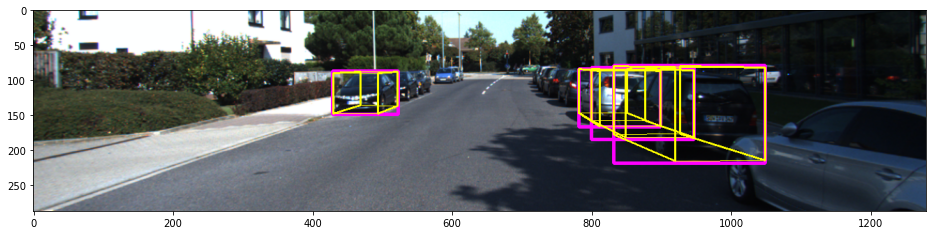

In [ ]:
# Sample 1
%matplotlib inline
from PIL import Image 
fig = plt.figure(figsize=(16,9))
index += 1
a = compute_once(index, is_draw=True)

# Video output

In [ ]:
%mkdir /content/video_2011_09_26_0009

In [ ]:
# Calculate the num of images
from glob import glob

img_list = glob("/content/visualDet3D/visualDet3D/data/kitti_raw/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/*.png")

print(len(img_list))

447


In [ ]:
# Make sequential image outputs
import time

for i in range(len(img_list)):
    image = compute_once(i, is_draw=False)
    path = video_path + "%010d.png" % i
    cv2.imwrite(path, image[:,:,::-1])

/content/visualDet3D/visualDet3D/networks/pipelines/testers.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [image.cuda().float().contiguous(), torch.tensor(P2).cuda().float()])


In [ ]:
# Make video output
import cv2
import numpy as np
 
img_array = []
for filename in sorted(glob('/content/video_2011_09_26_0009/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('/content/3DOD.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
# Save video
%cp /content/3DOD.avi /content/drive/MyDrive/project_2_dataset

In [ ]:
# Show 
from moviepy.editor import *

path="/content/3DOD.avi"

clip=VideoFileClip(path)
clip.ipython_display(width=1300)

Output hidden; open in https://colab.research.google.com to view.